# Using trained model with Twitter API

In [1]:
import requests
import pandas as pd
import json
import ast
import yaml
import numpy as np
import re
import matplotlib.pyplot as plt

In [2]:

# Twitter URL
def create_twitter_url():
    handle = "racism"
    max_results = 100
    mrf = "max_results={}".format(max_results)
    q = "query={}".format(handle)
    url = "https://api.twitter.com/2/tweets/search/recent?{}&{}".format(
        mrf, q
    )
    return url



In [3]:
# Authenticating and connecting to the Twitter API
def process_yaml():
    with open("config.yaml") as file: #This File containes bearer_token from twitter API
        return yaml.safe_load(file)


def create_bearer_token(data):
    return data["search_tweets_api"]["bearer_token"]


def twitter_auth_and_connect(bearer_token, url):
    headers = {"Authorization": "Bearer {}".format(bearer_token)}
    response = requests.request("GET", url, headers=headers)
    return response.json()

In [4]:
# Generating languages
def lang_data_shape(res_json):
    data_only = res_json["data"]
    doc_start = '"documents": {}'.format(data_only)
    str_json = "{" + doc_start + "}"
    dump_doc = json.dumps(str_json)
    doc = json.loads(dump_doc)
    return ast.literal_eval(doc)

In [5]:
url = create_twitter_url()
data = process_yaml()
bearer_token = create_bearer_token(data)
res_json = twitter_auth_and_connect(bearer_token, url)
# print(res_json)
documents = lang_data_shape(res_json)


In [6]:
df = pd.DataFrame.from_dict(documents['documents'])

In [7]:
df.drop(columns='id',inplace=True)
df.rename(columns={'text':'tweet'},inplace=True)
df.head()

,tweet
0,RT @IwriteOK: Talking to folks who are racist ...
1,"@GremlinHaru Reminds me of when someone said ""..."
2,"RT @TomiLahren: Here’s a wild guess, if Tom Br..."
3,@Win_Li1 @MarkDaymond @TPointUK @LozzaFox @TPU...
4,"RT @TomiLahren: Here’s a wild guess, if Tom Br..."


### Data Preprocessing Steps

In [8]:
def remove_pattern(input_text,pattern):
    r= re.findall(pattern, input_text)
    for i in r:
        input_text = re.sub(i, '', input_text)
    return input_text
                          

### Removing Handles

In [9]:
df['tidy_tweet'] = np.vectorize(remove_pattern)(df['tweet'],"@[\w]*") 
df.head(10)

,tweet,tidy_tweet
0,RT @IwriteOK: Talking to folks who are racist ...,RT : Talking to folks who are racist but not p...
1,"@GremlinHaru Reminds me of when someone said ""...","Reminds me of when someone said ""Astrology is..."
2,"RT @TomiLahren: Here’s a wild guess, if Tom Br...","RT : Here’s a wild guess, if Tom Brady suddenl..."
3,@Win_Li1 @MarkDaymond @TPointUK @LozzaFox @TPU...,Racism should be pretty clear cut...
4,"RT @TomiLahren: Here’s a wild guess, if Tom Br...","RT : Here’s a wild guess, if Tom Brady suddenl..."
5,"@Jim_Jordan Select Ignorant, corrupt, lying Re...","Select Ignorant, corrupt, lying Republicans w..."
6,This here is called Racism 101 https://t.co/0m...,This here is called Racism 101 https://t.co/0m...
7,RT @MattWalshBlog: Yeah good point. Why does t...,RT : Yeah good point. Why does the greatest pl...
8,RT @MattWalshBlog: Yeah good point. Why does t...,RT : Yeah good point. Why does the greatest pl...
9,RT @luobinghee: 1/25 alright so today we're fi...,RT : 1/25 alright so today we're finally getti...


In [10]:
df['tidy_tweet'] = df['tidy_tweet'].str.replace("[^a-zA-Z#]"," ")
df.head(10)

,tweet,tidy_tweet
0,RT @IwriteOK: Talking to folks who are racist ...,RT Talking to folks who are racist but not p...
1,"@GremlinHaru Reminds me of when someone said ""...",Reminds me of when someone said Astrology is...
2,"RT @TomiLahren: Here’s a wild guess, if Tom Br...",RT Here s a wild guess if Tom Brady suddenl...
3,@Win_Li1 @MarkDaymond @TPointUK @LozzaFox @TPU...,Racism should be pretty clear cut
4,"RT @TomiLahren: Here’s a wild guess, if Tom Br...",RT Here s a wild guess if Tom Brady suddenl...
5,"@Jim_Jordan Select Ignorant, corrupt, lying Re...",Select Ignorant corrupt lying Republicans w...
6,This here is called Racism 101 https://t.co/0m...,This here is called Racism https t co m...
7,RT @MattWalshBlog: Yeah good point. Why does t...,RT Yeah good point Why does the greatest pl...
8,RT @MattWalshBlog: Yeah good point. Why does t...,RT Yeah good point Why does the greatest pl...
9,RT @luobinghee: 1/25 alright so today we're fi...,RT alright so today we re finally getti...


## Removing short words (a,is,so etc..)

In [11]:
df['tidy_tweet'] = df['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3])) #removing words whose length is less than 3

In [12]:
df.head()

,tweet,tidy_tweet
0,RT @IwriteOK: Talking to folks who are racist ...,Talking folks racist primarily motivated racis...
1,"@GremlinHaru Reminds me of when someone said ""...",Reminds when someone said Astrology just racis...
2,"RT @TomiLahren: Here’s a wild guess, if Tom Br...",Here wild guess Brady suddenly started sucking...
3,@Win_Li1 @MarkDaymond @TPointUK @LozzaFox @TPU...,Racism should pretty clear
4,"RT @TomiLahren: Here’s a wild guess, if Tom Br...",Here wild guess Brady suddenly started sucking...


In [13]:
tokenized_tweet = df['tidy_tweet'].apply(lambda x:x.split()) #it will split all words by whitespace
tokenized_tweet.head()

0    [Talking, folks, racist, primarily, motivated,...
1    [Reminds, when, someone, said, Astrology, just...
2    [Here, wild, guess, Brady, suddenly, started, ...
3                      [Racism, should, pretty, clear]
4    [Here, wild, guess, Brady, suddenly, started, ...
Name: tidy_tweet, dtype: object

In [14]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) #it will stemmatized all words in tweet

In [15]:
#now let's combine these tokens back

for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i]) #concat all words into one sentence
df['tidy_tweet'] = tokenized_tweet

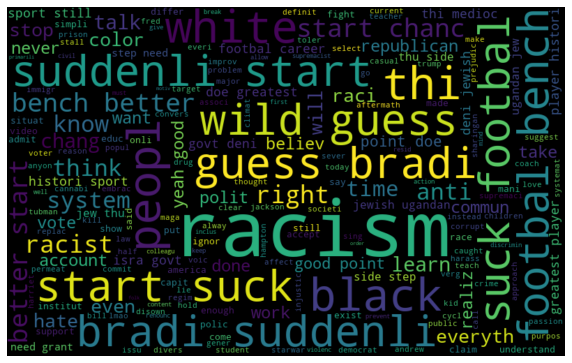

In [16]:
all_words = ' '.join([text for text in df['tidy_tweet']]) 
from wordcloud import WordCloud
wordcloud = WordCloud(width=800,height=500,random_state=21,max_font_size=110).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.savefig("images/WordCloud.png")
plt.show()

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
from joblib import dump, load


In [18]:
voc= load('voc.joblib')
model_naive = load('model_naive.joblib')

In [19]:
#Bag-of-words

#Each row in matrix M contains the frequency of tokens(words) in the document D(i)

bow_vectorizer = TfidfVectorizer(max_df=0.90 ,min_df=2 , max_features=1000,stop_words='english',vocabulary=voc)
bow = bow_vectorizer.fit_transform(df['tidy_tweet']) # tokenize and build vocabulary
bow.shape

(100, 1000)

In [20]:
predicted_naive = model_naive.predict(bow)

In [21]:
pd.options.display.max_colwidth = 180

In [22]:
#Some Positive Tweets
df['tweet'][predicted_naive==0]

0                                            RT @IwriteOK: Talking to folks who are racist but not primarily motivated by racism in order to educate them on common interests, combat th…
1                                                                                                       @GremlinHaru Reminds me of when someone said "Astrology is just racism for women"
2                                            RT @TomiLahren: Here’s a wild guess, if Tom Brady suddenly started sucking at football and was benched for a better starting QB, chances ar…
3                                                                                                   @Win_Li1 @MarkDaymond @TPointUK @LozzaFox @TPUSA Racism should be pretty clear cut...
4                                            RT @TomiLahren: Here’s a wild guess, if Tom Brady suddenly started sucking at football and was benched for a better starting QB, chances ar…
                                                                      

In [23]:
#Some Negative Tweets
df['tweet'][predicted_naive==1]

5     @Jim_Jordan Select Ignorant, corrupt, lying Republicans who spread hate,division,racism, corruption and Lies. Also Select Republicans are not smart enough to realize they are m...
11                                       @BasitAli92 @OF_Schroedinger @girlfromcanada @CriticalBard @ZombaeKillz I'm black and i hate how you believe there can't be racism from all side
17                                                                    Yes, there is racism, but Govt committed to improving situation: https://t.co/TJ5Pxz3LDH #ST #singapore #SGLiveNews
19                                           RT @LouiseRawAuthor: The utterly marvellous Dr  Shola gets the crayons out to explain it all to those with the ‘CAUCACITY’ to claim anti ra…
31                                                                                                            RT @ZFighterAmuro: @LeitungEvolved you're suggesting a sharingan for racism
47                                           RT @BreeNewsome: The inst